In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wrangle
import prepare_ravinder
from sklearn.model_selection import train_test_split
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
sns.set()
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

# Load Data

In [2]:
df = pd.read_csv('data/training_v2.csv')
id_col = 'encounter_id'

df1 = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')
df_obj = df1[(df1['Data Type'] == 'string') | (df1['Data Type'] == 'binary')]
cat_features = list(df_obj['Variable Name'].values)
for c in cat_features:
    if c not in df1.columns or c == 'hospital_death':
        cat_features.remove(c)
print(f'cat_features: {cat_features}')

cat_features: ['bmi', 'ethnicity', 'hospital_admit_source', 'icu_admit_type', 'icu_type', 'apache_2_diagnosis', 'apache_post_operative', 'gcs_unable_apache', 'ventilated_apache', 'cirrhosis', 'hepatic_failure', 'leukemia', 'solid_tumor_with_metastasis', 'apache_2_bodysystem']


In [3]:
df3 = pd.read_csv('data/training_v2.csv')



In [4]:
df3.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,1

In [5]:
df3[['apache_2_diagnosis','apache_3j_diagnosis', 'apache_3j_bodysystem', 'apache_2_bodysystem']].head(50)

,apache_2_diagnosis,apache_3j_diagnosis,apache_3j_bodysystem,apache_2_bodysystem
0,113.0,502.01,Sepsis,Cardiovascular
1,108.0,203.01,Respiratory,Respiratory
2,122.0,703.03,Metabolic,Metabolic
3,203.0,1206.03,Cardiovascular,Cardiovascular
4,119.0,601.01,Trauma,Trauma
5,301.0,403.01,Neurological,Neurologic
6,108.0,203.01,Respiratory,Respiratory
7,113.0,501.05,Sepsis,Cardiovascular
8,116.0,103.01,Cardiovascular,Cardiovascular
9,112.0,107.01,Cardiovascular,Cardiovascular


In [6]:
df.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,1

In [7]:
df['gcs'] = df.gcs_eyes_apache + df.gcs_motor_apache + df.gcs_verbal_apache

In [8]:
df.shape

(91713, 187)

In [9]:
# data_dict = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')
# data_dict
df1.head(2)

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient unit stay,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None


In [10]:
# data_dict['Category'].value_counts()

In [11]:
# data_dict['Data Type'].value_counts()

# Drop non_useful features

In [12]:
to_remove=['hospital_id','icu_id','patient_id','encounter_id','apache_4a_hospital_death_prob','apache_4a_icu_death_prob' ]
features = [col for col in df.columns if col not in to_remove]

In [13]:
def drop_correlated_features(df):
    df1 = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')
    df1 = df1[(df1['Data Type'] == 'string') | (df1['Data Type'] == 'binary')]
    cat_features = list(df1['Variable Name'].values)
    for c in cat_features:
        if c not in df1.columns or c == 'hospital_death':
            cat_features.remove(c)

    num_feature = [col for col in features if col not in cat_features and df[col].dtype != 'object']
    drop_columns=[]
    corr = df[num_feature].corr()



    columns = np.full((corr.shape[0],), True, dtype=bool)

    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >=0.99 :
                if columns[j] == True:
                    columns[j] = False
#                     print('col1: {} col2: {} - Correlation: {}'.format(df[num_feature].columns[i] , df[num_feature].columns[j], corr.iloc[i,j]))
            elif corr.iloc[i,j] <= -0.99:
                if columns[j] == True:
                    columns[j] = False

    drop_columns = df[num_feature].columns[columns == False].values
    return drop_columns

In [14]:
drop_columns = drop_correlated_features(df)

In [15]:
drop_columns

array(['paco2_for_ph_apache', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_mbp_noninvasive_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'h1_mbp_noninvasive_min', 'h1_sysbp_noninvasive_max',
       'd1_bilirubin_max', 'd1_creatinine_max', 'h1_albumin_min',
       'h1_bilirubin_min', 'h1_bun_min', 'h1_creatinine_min',
       'h1_hco3_min', 'h1_inr_max', 'h1_inr_min', 'h1_platelets_min',
       'h1_wbc_min'], dtype=object)

In [16]:
features = [col for col in features if col not in drop_columns]

In [17]:
df = df[features]
inv_cols=[s for s in df.columns.tolist() if "invasive" in s]
df.drop(inv_cols,axis=1,inplace=True)

In [18]:
df['icu_type']=df['icu_type'].replace({'CTICU':'CCU-CTICU',
                                              'Cardiac ICU':'CCT-CTICU',
                                              'CTICU':'CCT-CTICU',
                                              'CSICU':'SICU'})

df['hospital_admit_source']= df['hospital_admit_source'].replace({
                                        'Other ICU':"ICU",'ICU to SDU':"SDU",
                                       'Step-Down Unit (SDU)':"SDU",
                                      'Acute Care/Floor':"Floor",
                                      'Other Hospital':"Other"})


binary=[col for col in df.columns if df[col].nunique() == 2 and df[col].dtypes !='object']
categorical = [col for col in df.columns if df[col].dtypes == 'object']
df['apache_3j_diagnosis']= df['apache_3j_diagnosis'].fillna(0).astype(np.int64)
df['apache_2_diagnosis']= df['apache_2_diagnosis'].fillna(0).astype(np.int64)
categorical.append('apache_2_diagnosis')
categorical.append('apache_3j_diagnosis')

In [19]:
for col in binary:
    df[col]= df[col]+1
    df[col].fillna(0,inplace=True)
    df[col]= df[col].astype(np.int8).astype('category')

In [20]:
df['gcs_unable_apache'] = df['gcs_unable_apache'].astype('Int64')
for b in binary:
    df[b] = df[b].astype('Int64')

In [21]:
df.shape

(91713, 145)

In [22]:
# binary

In [23]:
numeric_col =[col for col in df.columns if  df[col].dtypes !='object' and col not in binary]

In [24]:
# identifier_features =data_dict[data_dict['Category']=='identifier']['Variable Name'].tolist() + ['icu_id']
# identifier_features

In [25]:
# type__features=['hospital_admit_source','icu_admit_source', 'icu_stay_type','icu_type']

In [26]:
redundant_features = ['readmission_status', 'apache_2_bodysystem', 'apache_2_diagnosis', 'apache_3j_diagnosis']

In [27]:
df.drop(columns = redundant_features, inplace = True)

In [28]:
numeric_col.remove('readmission_status')
numeric_col.remove('apache_2_diagnosis')
numeric_col.remove('apache_3j_diagnosis')
categorical.remove('apache_2_bodysystem')
categorical.remove('icu_stay_type')
categorical.remove('apache_2_diagnosis')
categorical.remove('apache_3j_diagnosis')

In [29]:
categorical

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_type',
 'apache_3j_bodysystem']

In [30]:
binary

['hospital_death',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [31]:
df.shape

(91713, 141)

In [32]:
train, test = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

# Handling Missing values

In [127]:
# Percentage of null values 
# (df.isnull().sum().sort_values()/df.shape[0]).plot.barh(figsize =(12,6))

## Dropping missing values

In [128]:
# # keep features that have less than 70% of nulls
# cut_off_percentage = .3
# n_of_nulls = int(cut_off_percentage * df.shape[0])

In [129]:
# df = df.dropna(axis=1, thresh = n_of_nulls)
# df.shape

## Imputation
Imputation was done based on the type of variable it was. Broadly, there are numerical and categorical variables.

### Numerical variables

In [36]:
# #get numeric feature names 
# # ['bmi','apache_2_diagnosis','apache_3j_diagnosis'] are suppose be numeric features, so add them back
# numeric_features = data_dict[data_dict['Data Type']=='numeric']['Variable Name'].tolist()+ ['bmi','apache_2_diagnosis','apache_3j_diagnosis']
# len(numeric_features)

In [37]:
# # get numeric features in the skewed dataset
# skewed_numeric_features = df.columns[df.columns.isin(numeric_features)]
# len(skewed_numeric_features)

In [33]:
numeric_df = train[numeric_col]
numeric_df.head(3)

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_bilirubin_max,h1_bun_max,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,gcs
59226,72.0,32.041330,154.9,0.061111,76.88,2.0,2.4,26.0,1.64,NaN,4.0,6.0,4.0,107.0,99.0,27.9,45.0,NaN,NaN,NaN,13.0,135.0,36.60,NaN,22.81,95.0,13.0,150.0,77.0,101.0,22.0,40.0,12.0,100.0,38.0,161.0,48.0,36.70,35.80,51.0,39.0,94.0,92.0,59.0,47.0,19.0,16.0,98.0,96.0,85.0,72.0,NaN,NaN,2.0,2.0,2.4,26.0,26.0,7.1,7.1,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0
81334,58.0,34.334291,190.5,0.032639,124.60,2.5,1.2,70.0,2.85,NaN,1.0,1.0,1.0,319.0,138.0,37.4,47.0,NaN,NaN,NaN,53.0,117.0,36.20,NaN,16.20,137.0,14.0,138.0,83.0,144.0,42.0,53.0,17.0,99.0,81.0,161.0,77.0,37.80,36.20,64.0,22.0,128.0,116.0,86.0,42.0,53.0,30.0,98.0,96.0,121.0,96.0,37.80,37.40,2.6,2.5,1.0,70.0,63.0,8.5,8.1,2.44,319.0,212.0,36.0,32.0,11.9,11.9,37.4,37.4,1.4,1.4,2.7,1.9,358.0,358.0,4.3,4.1,123.0,152.0,16.20,16.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
67173,78.0,32.764004,165.0,2.527083,89.20,NaN,NaN,NaN,NaN,NaN,3.0,6.0,5.0,NaN,41.0,NaN,63.0,NaN,NaN,NaN,12.0,NaN,36.33,NaN,NaN,108.0,44.0,70.0,44.0,116.0,63.0,20.0,12.0,98.0,91.0,149.0,104.0,37.22,36.33,85.0,64.0,53.0,50.0,85.0,85.0,18.0,13.0,97.0,97.0,138.0,125.0,37.22,36.44,NaN,NaN,NaN,12.0,12.0,NaN,NaN,0.56,115.0,115.0,23.0,23.0,13.7,13.7,40.7,40.7,NaN,NaN,NaN,NaN,164.0,164.0,4.4,4.4,141.0,141.0,7.59,7.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0


In [34]:
binary_df = train[binary]
binary_df.head(3)

,hospital_death,elective_surgery,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
59226,2,1,1,1,1,1,1,1,1,1,1,1,1,1,2
81334,1,1,1,1,1,1,2,1,1,2,1,1,1,1,1
67173,1,2,2,1,1,1,1,1,1,1,1,1,1,1,2


In [37]:
categorical_df = train[categorical]
categorical_df.isnull().sum()

ethnicity                 1123
gender                      19
hospital_admit_source    17227
icu_admit_source            92
icu_type                     0
apache_3j_bodysystem      1346
dtype: int64

In [35]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

In [39]:
imp = IterativeImputer(max_iter=3, verbose=0)
imp.fit(numeric_df)
imputed_df = imp.transform(numeric_df)
imputed_df = pd.DataFrame(imputed_df, columns=numeric_df.columns, index = numeric_df.index)

In [38]:
for col in categorical:
    categorical_df[col].fillna(categorical_df[col].mode()[0],inplace=True)

In [40]:
imputed_df

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_bilirubin_max,h1_bun_max,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,gcs
59226,72.0,32.041330,154.9,0.061111,76.880000,2.000000,2.400000,26.000000,1.640000,0.642183,4.0,6.0,4.0,107.000000,99.0,27.900000,45.0,39.783308,128.551914,7.328135,13.000000,135.000000,36.600000,293.475101,22.810000,95.0,13.0,150.0,77.0,101.0,22.0,40.000000,12.000000,100.0,38.0,161.0,48.0,36.700000,35.800000,51.0,39.0,94.0,92.0,59.0,47.0,19.000000,16.000000,98.0,96.0,85.0,72.0,36.269157,36.194532,2.000000,2.000000,2.400000,26.0,26.0,7.100000,7.100000,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.800000,1.800000,2.600000,2.600000,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,2.194217,2.349326,23.643118,7.747787,7.658943,1.590038,127.517006,124.157709,21.122624,11.475711,11.178202,36.378488,35.560253,2.648156,2.605164,77.381423,4.105629,4.079440,136.944569,136.359229,22.423979,45.615428,35.713402,7.355204,7.290318,191.746988,103.150555,260.189286,204.016969,42.770634,41.517513,7.343088,7.330345,168.935976,142.597077,235.685428,242.007713,14.0
81334,58.0,34.334291,190.5,0.032639,124.600000,2.500000,1.200000,70.000000,2.850000,0.639896,1.0,1.0,1.0,319.000000,138.0,37.400000,47.0,53.466975,115.983909,7.375525,53.000000,117.000000,36.200000,891.335436,16.200000,137.0,14.0,138.0,83.0,144.0,42.0,53.000000,17.000000,99.0,81.0,161.0,77.0,37.800000,36.200000,64.0,22.0,128.0,116.0,86.0,42.0,53.000000,30.000000,98.0,96.0,121.0,96.0,37.800000,37.400000,2.600000,2.500000,1.000000,70.0,63.0,8.500000,8.100000,2.44,319.0,212.0,36.0,32.0,11.9,11.9,37.4,37.4,1.400000,1.400000,2.700000,1.900000,358.0,358.0,4.3,4.1,123.0,152.0,16.20,16.20,2.666535,0.987475,67.758736,8.358160,8.313527,2.698839,199.041315,206.643309,33.455166,10.647198,11.224860,34.637430,36.108901,3.194004,2.974276,358.522551,4.053550,4.265090,135.979071,138.834120,15.736417,53.898847,47.531658,7.389318,7.348017,121.697880,93.145823,216.794270,188.654034,49.815689,50.839669,7.343912,7.367905,96.574102,120.375310,233.105483,225.971269,3.0
67173,78.0,32.764004,165.0,2.527083,89.200000,2.990170,1.019065,12.270802,0.779957,0.529971,3.0,6.0,5.0,106.251117,41.0,40.830336,63.0,41.712946,117.754409,7.360492,12.000000,140.896779,36.330000,1503.997906,7.351831,108.0,44.0,70.0,44.0,116.0,63.0,20.000000,12.000000,98.0,91.0,149.0,104.0,37.220000,36.330

### Categorical variables

In [45]:
# categorical_features = data_dict[data_dict['Data Type']!='numeric']['Variable Name'].tolist()

In [46]:
#remove ['bmi','apache_2_diagnosis','apache_3j_diagnosis'] non_categorical features
# categorical_features =[feature for feature in categorical_features if feature not in ['bmi','apache_2_diagnosis','apache_3j_diagnosis']]

In [47]:
# skewed_categorical_features = df.columns[df.columns.isin(categorical_features)]
# len(skewed_categorical_features)

In [48]:
# categorical_df = df[skewed_categorical_features]
# categorical_df.head(3)

In [49]:
# # fill the null with the most occurred values
# # df.series.mode() returns a series. so [0] exact value of the series
# for feature in skewed_categorical_features:
#     categorical_df[feature].fillna(categorical_df[feature].mode()[0],inplace=True)

In [41]:
numeric_df.shape, categorical_df.shape, binary_df.shape

((73370, 119), (73370, 6), (73370, 15))

In [59]:
# # concat two data frame together horizontally
# complet_df = pd.concat([imputed_df, categorical_df], axis = 1)
# complet_df

# Feature creation

The Glasgow Coma Scale (GCS) is the most common scoring system used to describe the level of consciousness in a person following a traumatic brain injury.
Clinicians use this scale to rate the best eye opening response, the best verbal response, and the best motor response an individual makes. The final GCS score or grade is the sum of these numbers.

# Feature transformation

In [50]:
# complet_df['apache_2_bodysystem'].value_counts().plot.barh(figsize =(12,6))

In [51]:
# complet_df['apache_2_bodysystem'].value_counts()

In [52]:
# reset 'Undefined Diagnoses' to 'Undefined diagnoses'
# Use loc to reset values
# complet_df.loc[complet_df['apache_2_bodysystem']=='Undefined Diagnoses','apache_2_bodysystem'] ='Undefined diagnoses'

In [53]:
# complet_df['apache_2_bodysystem'].value_counts().plot.barh(figsize =(12,6))

# Feature selection

# Encoding

## Label encoding
Encode Male as 1 and female 0

In [42]:
# numeric_df
# binary_df
# categorical_df

In [65]:
# categorical_df['gender']= categorical_df['gender'].apply(lambda x: 1 if x =='M' else 0).astype(str)

In [67]:
categorical_df.dtypes

ethnicity                object
gender                   object
hospital_admit_source    object
icu_admit_source         object
icu_type                 object
apache_3j_bodysystem     object
dtype: object

In [60]:
categorical_df.apache_3j_bodysystem.value_counts()

Cardiovascular          23938
Neurological             9576
Sepsis                   9395
Respiratory              9283
Gastrointestinal         7220
Metabolic                6101
Trauma                   3084
Genitourinary            1740
Musculoskeletal/Skin      936
Hematological             503
Gynecological             248
Name: apache_3j_bodysystem, dtype: int64

## One hot encoding

In [61]:
from sklearn.preprocessing import OneHotEncoder

In [43]:
categorical_df.columns

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_type', 'apache_3j_bodysystem'],
      dtype='object')

In [47]:
binary_df.drop(columns=['hospital_death'], inplace = True)

In [45]:
l = ['ethnicity','gender','hospital_admit_source', 'icu_admit_source','icu_type', 'apache_3j_bodysystem',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [48]:
train1 = pd.concat([categorical_df, binary_df], axis =1)



In [49]:
train1.head(2)

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_type,apache_3j_bodysystem,elective_surgery,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
59226,Caucasian,F,SDU,Floor,MICU,Sepsis,1,1,1,1,1,1,1,1,1,1,1,1,1,2
81334,Caucasian,M,Direct Admit,Accident & Emergency,Med-Surg ICU,Sepsis,1,1,1,1,1,2,1,1,2,1,1,1,1,1


In [50]:
train1 = prepare_ravinder.encode(train1, l)

In [42]:
categorical_df.to_csv('data/categorical.csv')

In [43]:
# for col in categorical_df.columns:
#     print(col)
#     categorical_df = prepare_ravinder.label_encoder(categorical_df, col)

# # empty_df = pd.DataFrame(index=categorical_df.index )
# # pd.concat([encoded_df1,empty_df], axis =1)

In [73]:
# ohe = OneHotEncoder(sparse=False, categories='auto')
# encoded_matrix = ohe.fit_transform(categorical_df[features_need_encoding])

In [44]:
# ohe.categories_[0]

In [45]:
# encoded_df1 = pd.DataFrame(encoded_matrix, columns=ohe.categories_[0], index=categorical_df[features_need_encoding].index)
# encoded_df1.head(3)

In [46]:
# features_need_encoding = ['apache_3j_bodysystem']
# ohe = OneHotEncoder(sparse=False, categories='auto')
# encoded_matrix = ohe.fit_transform(categorical_df[features_need_encoding])
# encoded_df2 = pd.DataFrame(encoded_matrix, columns=ohe.categories_[0], index=categorical_df[features_need_encoding].index)
# encoded_df2.head(3)

In [52]:
numeric_df.shape, categorical_df.shape, binary_df.shape

((73370, 119), (73370, 6), (73370, 15))

In [58]:
type(binary_df)

pandas.core.frame.DataFrame

In [69]:
imputed_df.shape, categorical_df.shape, binary_df.shape

((73370, 119), (73370, 41), (73370, 15))

In [51]:
train = pd.concat([imputed_df ,train1], axis =1)
train

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_bilirubin_max,h1_bun_max,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,gcs,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_F,gender_M,hospital_admit_source_Chest Pain Center,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_ICU,hospital_admit_source_Observation,hospital_admit_source_Operating Room,hospital_admit_source_Other,hospital_admit_source_PACU,hospital_admit_source_Recovery Room,hospital_admit_source_SDU,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_type_CCT-CTICU,icu_type_CCU-CTICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,apache_3j_bodysystem_Cardiovascular,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,elective_surgery_1,elective_surgery_2,apache_post_operative_1,apache_post_operative_2,arf_apache_0,arf_apache_1,arf_apache_2,gcs_unable_apache_0,gcs_unable_apache_1,gcs_unable_apache_2,intubated_apache_0,intubated_apache_1,intubated_apache_2,ventilated_apache_0,ventilated_apache_1,ventilated_apache_2,aids_0,aids_1,aids_2,cirrhosis_0,cirrhosis_1,cirrhosis_2,diabetes_mellitus_0,diabetes_mellitus_1,diabetes_mellitus_2,hepatic_failure_0,hepatic_failure_1,hepatic_failure_2,immunosuppression_0,immunosuppression_1,immunosuppression_2,leukemia_0,leukemia_1,leukemia_2,lymphoma_0,lymphoma_1,lymphoma_2,solid_tumor_with_metastasis_0,solid_tumor_with_metastasis_1,solid_tumor_with_metastasis_2
59226,72.0,32.041330,154.9,0.061111,76.880000,2.000000,2.400000,26.000000,1.640000,0.642183,4.0,6.0,4.0,107.000000,99.0,27.900000,45.0,39.783308,128.551914,7.328135,13.000000,135.000000,36.600000,293.475101,22.810000,95.0,13.0,150.0,77.0,101.0,22.0,40.000000,12.000000,100.0,38.0,161.0,48.0,36.700000,35.800000,51.0,39.0,94.0,92.0,59.0,47.0,19.000000,16.000000,98.0,96.0,85.0,7

In [76]:
# def one_hot_encoder(dataset):
#     encoded_df = pd.DataFrame(index=dataset.index)
#     features = dataset.columns.tolist()
#     for i,features in enumerate(features):
#         ohe = OneHotEncoder(sparse=False, categories='auto')
#         encoded_matrix = ohe.fit_transform(dataset[[feature]])
#         encoded_dfi = pd.DataFrame(encoded_matrix, columns=ohe.categories_[0], index=dataset[feature].index)
#         encoded_df = pd.concat([encoded_df,encoded_dfi], axis =1)
#     return encoded_df


In [77]:
# One hot encode selected features
# dataset = complet_df[['ethnicity', 'apache_3j_bodysystem']]
# encoded_df = one_hot_encoder(dataset)
# encoded_df

In [47]:
# Concat encoded dataframe to the complete df
# Drop the selected features
# complet_df = pd.concat([complet_df, encoded_df], axis=1).drop(columns =['ethnicity', 'apache_3j_bodysystem'])

# Modeling

## Baseline

In [80]:
(complet_df.shape[0]-(complet_df['hospital_death']).sum())/complet_df.shape[0]

0.9136981671082617

## Logist regression

### Building a Model

In [81]:
from sklearn.linear_model import LogisticRegression

In [105]:
param = ['height',
 'temp_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_max',
 'd1_temp_min']
for p in param:  
    complet_df['bool_'+ p] = np.where(pd.notnull(complet_df[p]), 1,0)

In [52]:
train

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_bilirubin_max,h1_bun_max,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,gcs,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_F,gender_M,hospital_admit_source_Chest Pain Center,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_ICU,hospital_admit_source_Observation,hospital_admit_source_Operating Room,hospital_admit_source_Other,hospital_admit_source_PACU,hospital_admit_source_Recovery Room,hospital_admit_source_SDU,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_type_CCT-CTICU,icu_type_CCU-CTICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,apache_3j_bodysystem_Cardiovascular,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,elective_surgery_1,elective_surgery_2,apache_post_operative_1,apache_post_operative_2,arf_apache_0,arf_apache_1,arf_apache_2,gcs_unable_apache_0,gcs_unable_apache_1,gcs_unable_apache_2,intubated_apache_0,intubated_apache_1,intubated_apache_2,ventilated_apache_0,ventilated_apache_1,ventilated_apache_2,aids_0,aids_1,aids_2,cirrhosis_0,cirrhosis_1,cirrhosis_2,diabetes_mellitus_0,diabetes_mellitus_1,diabetes_mellitus_2,hepatic_failure_0,hepatic_failure_1,hepatic_failure_2,immunosuppression_0,immunosuppression_1,immunosuppression_2,leukemia_0,leukemia_1,leukemia_2,lymphoma_0,lymphoma_1,lymphoma_2,solid_tumor_with_metastasis_0,solid_tumor_with_metastasis_1,solid_tumor_with_metastasis_2
59226,72.0,32.041330,154.9,0.061111,76.880000,2.000000,2.400000,26.000000,1.640000,0.642183,4.0,6.0,4.0,107.000000,99.0,27.900000,45.0,39.783308,128.551914,7.328135,13.000000,135.000000,36.600000,293.475101,22.810000,95.0,13.0,150.0,77.0,101.0,22.0,40.000000,12.000000,100.0,38.0,161.0,48.0,36.700000,35.800000,51.0,39.0,94.0,92.0,59.0,47.0,19.000000,16.000000,98.0,96.0,85.0,7

In [54]:
train2, test = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

In [55]:
y = train2[['hospital_death']]
y['hospital_death'] = y['hospital_death']-1
X = train

In [69]:
y['hospital_death'] = y['hospital_death'].astype(int)

In [56]:
X.shape, y.shape

((73370, 200), (73370, 1))

In [68]:
y.dtypes.value_counts()

Int64    1
dtype: int64

In [136]:
logit = LogisticRegression(C = 0.1,  max_iter=250)
logit.fit(X, y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=250,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [137]:
y_pred = logit.predict(X)

### AUC Roc score

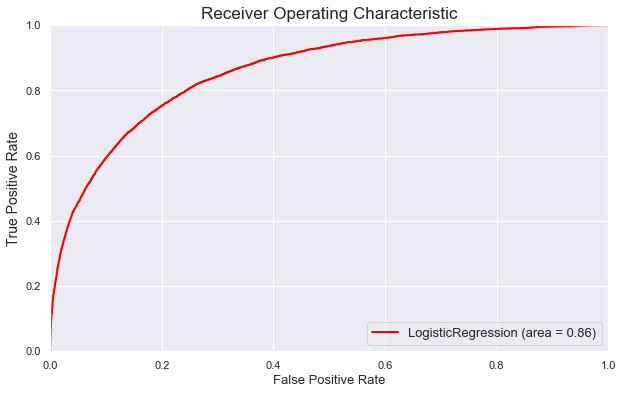

In [138]:
plt.figure(figsize=(10,6))

y_pred = logit.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression (area = %0.2f)' % auc(fpr, tpr))
         
# y_pred = knn.predict_proba(X_validate_scaled)[:,1]
# fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
# plt.plot(fpr, tpr, color='yellow', lw=3, label='KNN (area = %0.2f)' % auc(fpr, tpr))


# y_pred = clf.predict_proba(X_validate_scaled)[:,1]
# fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
# plt.plot(fpr, tpr, color='brown', lw=2, label='RandomForest (area = %0.2f)' % auc(fpr, tpr))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

## Decision Tree

### Building a model

In [88]:
from sklearn.tree import DecisionTreeClassifier


In [148]:
dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [149]:
dt.score(X, y)

0.9466675753032575

### Auc Roc score

In [150]:
lr_probs = dt.predict_proba(X)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_probs 

array([0.75      , 0.41935484, 0.00853812, ..., 0.00853812, 0.07106599,
       0.06024096])

Logistic: ROC AUC=0.890


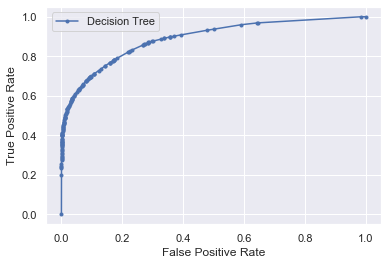

In [151]:
# calculate scores
# ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(y, lr_probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Decision Tree')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#  Some_thing to do later

In [ ]:
object_df = reduced_dim_df.select_dtypes('object')
object_df.nunique()

Systems that estimate the risk of hospital death based on severity of disease scoring have become increasingly popular in the last 20 years, particularly in the field of critical care medicine. The first 2 to be introduced were the Acute Physiology and Chronic Health Evaluation (APACHE) System in 1981 and the Simplified Acute Physiology Score (SAPS) in 1988. Further research resulted in "improved" editions, APACHE II[1] in 1985, and SAPS II[2] in 1993. A later version, APACHE III,[3] is now coming into general use.
Briefly, the APACHE III is used to produce an equation predicting hospital mortality after the first day of ICU treatment. There are 4 components: age, major disease category (reason for ICU admission), acute (current) physiology, and prior site of healthcare (eg, hospital floor, emergency room, etc.)

So **just use apache_3j_bodysystem**

In [ ]:
(object_df['apache_3j_bodysystem'] != object_df['apache_2_bodysystem']).sum()

In [ ]:
object_df['icu_type'].unique()